<a href="https://colab.research.google.com/github/saimayasmeen4/SAR_LPNET_Code/blob/main/sp_atte_LPNET_SAR_colab_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-44113f3c-0678-40c9-010a-42276e2518b9)


In [ ]:
# import os
# path, dirs, files = next(os.walk('/content/drive/MyDrive/SAR_LPNET_NEW/test_img/Noisy_R'))
# file_count = len(files)
# print(file_count)


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#!pip uninstall tensorflow==1.14.0
!pip install tensorflow==1.14.0
!pip install tensorflow-gpu==1.14.0

In [ ]:
# %tensorflow_version 1.14.0

In [ ]:
import tensorflow as tf
from tqdm import tqdm, tqdm_notebook
# tf_upgrade_v2 \
#   --intree my_project/ \
#   --outtree my_project_v2/ \
#   --reportfile report.txt

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
%cd /content/drive/MyDrive/SAR_LPNET_NEW

/content/drive/.shortcut-targets-by-id/1V4PECjAHfjrUjZqJK8ugx2hOODDIuMK9/SAR_LPNET_NEW


# **Model**

In [ ]:


# import torch
import math
# import torch.nn as nn
# import torch.nn.functional as F
import numpy as np
import tensorflow as tf


num_pyramids = 5  # number of pyramid levels
num_blocks =  5   # number of recursive blocks
num_feature = 32  # number of feature maps
num_channels = 1  # number of input's channels 


# leaky ReLU
def lrelu(x, leak = 0.2, name = 'lrelu'):   
    with tf.variable_scope(name):
         return tf.maximum(x, leak*x, name = name)   



######## Laplacian and Gaussian Pyramid ########
def lap_split(img,kernel):
    with tf.name_scope('split'):
        low = tf.nn.conv2d(img, kernel, [1,2,2,1], 'SAME')
        low_upsample = tf.nn.conv2d_transpose(low, kernel*4, tf.shape(img), [1,2,2,1])
        high = img - low_upsample
    return low, high

def LaplacianPyramid(img,kernel,n):
    levels = []
    for i in range(n):
        img, high = lap_split(img, kernel)
        levels.append(high)
    levels.append(img)
    return levels[::-1]

def GaussianPyramid(img,kernel,n):
    levels = []
    low = img
    for i in range(n):
        low = tf.nn.conv2d(low, kernel, [1,2,2,1], 'SAME')
        levels.append(low)
    return levels[::-1]
######## Laplacian and Gaussian Pyramid ######## 



# create kernel
def create_kernel(name, shape, initializer=tf.contrib.layers.xavier_initializer()):
    regularizer = tf.contrib.layers.l2_regularizer(scale = 1e-4)
    new_variables = tf.get_variable(name=name, shape=shape, initializer=initializer,
                                    regularizer=regularizer)
    return new_variables


# sub network
def subnet(images,num_feature):
    kernel0 = create_kernel(name='weights_0', shape=[3, 3, num_channels, num_feature])
    biases0 = tf.Variable(tf.constant(0.0, shape=[num_feature], dtype=tf.float32), trainable=True, name='biases_0')  
  
    kernel1 = create_kernel(name='weights_1', shape=[3, 3, num_feature, num_feature])
    biases1 = tf.Variable(tf.constant(0.0, shape=[num_feature], dtype=tf.float32), trainable=True, name='biases_1')  

    kernel2 = create_kernel(name='weights_2', shape=[1, 1, num_feature, num_feature])
    biases2 = tf.Variable(tf.constant(0.0, shape=[num_feature], dtype=tf.float32), trainable=True, name='biases_2')  

    kernel3 = create_kernel(name='weights_3', shape=[3, 3, num_feature, num_feature])
    biases3 = tf.Variable(tf.constant(0.0, shape=[num_feature], dtype=tf.float32), trainable=True, name='biases_3')  
   
    kernel4 = create_kernel(name='weights_4', shape=[1, 1, num_feature, num_channels])
    biases4 = tf.Variable(tf.constant(0.0, shape=[num_channels], dtype=tf.float32), trainable=True, name='biases_4')  

  #  1st layer
    with tf.variable_scope('1st_layer'):    
         conv0 = tf.nn.conv2d(images, kernel0, [1, 1, 1, 1], padding='SAME')
         bias0 = tf.nn.bias_add(conv0, biases0) 
         bias0 = lrelu(bias0) # leaky ReLU

         out_block =  bias0

  #  recursive blocks. First 4 blocks are of SB. Last block is for FEB
    for i in range(num_blocks):
        with tf.variable_scope('block_%s'%(i+1)):
             conv1 = tf.nn.conv2d(out_block, kernel1, [1, 1, 1, 1], padding='SAME')
             bias1 = tf.nn.bias_add(conv1, biases1) 
             bias1 = lrelu(bias1) 
  
             conv2 = tf.nn.conv2d(bias1, kernel2, [1, 1, 1, 1], padding='SAME')
             bias2 = tf.nn.bias_add(conv2, biases2) 
             bias2 = lrelu(bias2) 
  
             conv3 = tf.nn.conv2d(bias2, kernel3, [1, 1, 1, 1], padding='SAME')
             bias3 = tf.nn.bias_add(conv3, biases3) 
             bias3 = lrelu(bias3) 

 

            #  out_block = bias3
             out_block = tf.add(bias3, bias0) #  shortcut

    # conv1 -> conv2 -> conv3 (dilation) -> conv1 -> conv2 -> conv3 (dilation) -> conv1 -> conv2 -> conv3 (dilation) -> conv1 -> conv2 -> conv3 (dilation)
    
    # Part of FEB
    kernel_feb = create_kernel(name='kernel_attention', shape=[1, 1, num_feature, num_channels])
    # biases_attention = tf.Variable(tf.constant(0.0, shape=[num_channels], dtype=tf.float32), trainable=True, name='biases_attention') 
    out_block = tf.nn.conv2d(out_block, kernel_feb, [1, 1, 1, 1], padding='SAME')
    conv1_out_block = out_block
    # bias_attention = tf.nn.bias_add(conv1, biases_attention)
    
     

    out_block = tf.concat([out_block, images], -1)
    out_block = tf.nn.tanh(out_block, name ='tanh')

    # attention_feature = channel_attention(out_block, 'ch_at', ratio=8)
    attention_feature = spatial_attention(out_block, 'sp_at')
    
    conv_1_out_block=attention_feature
    out_block=conv_1_out_block


    

    # attention block
    kernel_attention_2 = create_kernel(name='kernel_attention_2', shape=[1, 1, num_channels*2, num_channels])
    biases_attention_2 = tf.Variable(tf.constant(0.0, shape=[num_channels], dtype=tf.float32), trainable=True, name='biases_attention_2') 
    out_block = tf.nn.conv2d(out_block, kernel_attention_2, [1, 1, 1, 1], padding='SAME')
    out_block = tf.nn.bias_add(out_block, biases_attention_2) 

    out_block = tf.multiply(out_block, conv1_out_block)

   #  reconstruction layer attention
    with tf.variable_scope('recons'):    
        #  conv = tf.nn.conv2d(out_block, kernel4, [1, 1, 1, 1], padding='SAME')
        #  recons = tf.nn.bias_add(conv, biases4) 

         final_out = tf.add(out_block, images) #  shortcut
  
    return final_out

def spatial_attention(input_feature, name):
  kernel_size = 7
  kernel_initializer = tf.contrib.layers.variance_scaling_initializer()
  with tf.variable_scope(name):
    avg_pool = tf.reduce_mean(input_feature, axis=[3], keepdims=True)
    assert avg_pool.get_shape()[-1] == 1
    max_pool = tf.reduce_max(input_feature, axis=[3], keepdims=True)
    assert max_pool.get_shape()[-1] == 1
    concat = tf.concat([avg_pool,max_pool], 3)
    assert concat.get_shape()[-1] == 2
    
    concat = tf.layers.conv2d(concat,
                              filters=1,
                              kernel_size=[kernel_size,kernel_size],
                              strides=[1,1],
                              padding="same",
                              activation=None,
                              kernel_initializer=kernel_initializer,
                              use_bias=False,
                              name='conv')
    assert concat.get_shape()[-1] == 1
    concat = tf.sigmoid(concat, 'sigmoid')
    
  return input_feature * concat


# LPNet structure
def inference(images):
    with tf.variable_scope('inference', reuse=tf.AUTO_REUSE):

         k = np.float32([.0625, .25, .375, .25, .0625]) # Gaussian kernel for image pyramid
         k = np.outer(k, k) 
         kernel = k[:,:,None,None]/k.sum()*np.eye(num_channels, dtype=np.float32)
         
         pyramid = LaplacianPyramid(images, kernel, (num_pyramids - 1)) # rainy Laplacian pyramid

         
       # subnet 1
         with tf.variable_scope('subnet1'):  
              out1 = subnet( pyramid[0], int((num_feature)/16) )
              out1 = tf.nn.relu(out1) 
              out1_t = tf.nn.conv2d_transpose(out1, kernel*4, tf.shape(pyramid[1]), [1,2,2,1])
           
       # subnet 2
         with tf.variable_scope('subnet2'):  
              out2 = subnet( pyramid[1], int((num_feature)/8) )
              out2 = tf.add(out2, out1_t)
              out2 = tf.nn.relu(out2) 
              out2_t = tf.nn.conv2d_transpose(out2, kernel*4, tf.shape(pyramid[2]), [1,2,2,1])

       # subnet 3
         with tf.variable_scope('subnet3'):  
              out3 = subnet( pyramid[2], int((num_feature)/4) )
              out3 = tf.add(out3, out2_t)
              out3 = tf.nn.relu(out3) 
              out3_t = tf.nn.conv2d_transpose(out3, kernel*4, tf.shape(pyramid[3]), [1,2,2,1])
     
       # subnet 4
         with tf.variable_scope('subnet4'):  
              out4 = subnet( pyramid[3], int((num_feature)/2) )
              out4 = tf.add(out4, out3_t)
              out4 = tf.nn.relu(out4) 
              out4_t = tf.nn.conv2d_transpose(out4, kernel*4, tf.shape(pyramid[4]), [1,2,2,1])
     
       # subnet 5
         with tf.variable_scope('subnet5'):  
              out5 = subnet( pyramid[4], int(num_feature) )
              out5 = tf.add(out5, out4_t)
              out5 = tf.nn.relu(out5) 
              
         outout_pyramid = []        
         outout_pyramid.append(out1)
         outout_pyramid.append(out2)
         outout_pyramid.append(out3)
         outout_pyramid.append(out4)
         outout_pyramid.append(out5)
         
         return outout_pyramid


if __name__ == '__main__':
    tf.reset_default_graph()   
    
    input_x = tf.placeholder(tf.float32, [10,None,None,num_channels])
    
    outout_pyramid  = inference(input_x)
    var_list = tf.trainable_variables()   
    print("Total parameters' number: %d" 
         %(np.sum([np.prod(v.get_shape().as_list()) for v in var_list])))  



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Total parameters' number: 27356


In [ ]:
import tensorflow as tf

print(tf.__version__)

In [ ]:
# import os

# path, dirs, files = next(os.walk('/content/drive/MyDrive/SAR/virtual_sar_training_set/noisy_1c_full/'))
# file_count = len(files)
# print(file_count)


# **Training**

In [ ]:
!ls

20000 ['../SAR_LPNET_NEW/R_Proposed_Dataset/00002.jpg', '../SAR_LPNET_NEW/R_Proposed_Dataset/00001.jpg', '../SAR_LPNET_NEW/R_Proposed_Dataset/00006.jpg', '../SAR_LPNET_NEW/R_Proposed_Dataset/00014.jpg', '../SAR_LPNET_NEW/R_Proposed_Dataset/00018.jpg', '../SAR_LPNET_NEW/R_Proposed_Dataset/00013.jpg', '../SAR_LPNET_NEW/R_Proposed_Dataset/00009.jpg', '../SAR_LPNET_NEW/R_Proposed_Dataset/00015.jpg', '../SAR_LPNET_NEW/R_Proposed_Dataset/00011.jpg', '../SAR_LPNET_NEW/R_Proposed_Dataset/00023.jpg', '../SAR_LPNET_NEW/R_Proposed_Dataset/00012.jpg', '../SAR_LPNET_NEW/R_Proposed_Dataset/00016.jpg', '../SAR_LPNET_NEW/R_Proposed_Dataset/00008.jpg', '../SAR_LPNET_NEW/R_Proposed_Dataset/00010.jpg', '../SAR_LPNET_NEW/R_Proposed_Dataset/00019.jpg', '../SAR_LPNET_NEW/R_Proposed_Dataset/00004.jpg', '../SAR_LPNET_NEW/R_Proposed_Dataset/00022.jpg', '../SAR_LPNET_NEW/R_Proposed_Dataset/00003.jpg', '../SAR_LPNET_NEW/R_Proposed_Dataset/00007.jpg', '../SAR_LPNET_NEW/R_Proposed_Dataset/00021.jpg', '../SAR_LPNET

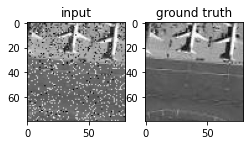

Streaming output truncated to the last 5000 lines.
4490 / 100000 iteraions, Training Loss  = 0.2006, running time = 59.8 s
4491 / 100000 iteraions, Training Loss  = 0.1790, running time = 59.9 s
4492 / 100000 iteraions, Training Loss  = 0.1639, running time = 59.9 s
4493 / 100000 iteraions, Training Loss  = 0.1643, running time = 60.0 s
4494 / 100000 iteraions, Training Loss  = 0.1679, running time = 60.0 s
4495 / 100000 iteraions, Training Loss  = 0.1463, running time = 60.0 s
4496 / 100000 iteraions, Training Loss  = 0.1824, running time = 60.1 s
4497 / 100000 iteraions, Training Loss  = 0.1679, running time = 60.1 s
4498 / 100000 iteraions, Training Loss  = 0.1524, running time = 60.2 s
4499 / 100000 iteraions, Training Loss  = 0.1419, running time = 60.2 s
4500 / 100000 iteraions, Training Loss  = 0.1677, running time = 60.2 s
4501 / 100000 iteraions, Training Loss  = 0.1495, running time = 60.3 s
4502 / 100000 iteraions, Training Loss  = 0.1818, running time = 60.3 s
4503 / 100000

In [ ]:
import os
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# from model import inference, GaussianPyramid 


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


num_pyramids = 5       # number of pyramid levels
learning_rate = 1e-3   # learning rate
iterations = int(100000)  # iterations
batch_size = 10        # batch size
num_channels = 1       # number of input's channels 
patch_size = 80        # patch size 
save_model_path = './model/pre_trained/with_attention_feature32'  # path of saved model
model_name = 'model-epoch'    # name of saved model

input_path = '../SAR_LPNET_NEW/R_Proposed_Dataset/' # Noisy images
gt_path = '../SAR_LPNET_NEW/clean_1c/'    # ground truth  

# randomly select image patches
def _parse_function(input_path, gt_path, patch_size = patch_size):   
    image_string = tf.read_file(input_path)  
    image_decoded = tf.image.decode_png(image_string, channels=num_channels)  
    rainy = tf.cast(image_decoded, tf.float32)/255.0
          
    image_string = tf.read_file(gt_path)  
    image_decoded = tf.image.decode_png(image_string, channels=num_channels)  
    label = tf.cast(image_decoded, tf.float32)/255.0
          
    t = time.time()
    Data = tf.random_crop(rainy, [patch_size, patch_size ,num_channels],seed = t)   # randomly select patch
    Label = tf.random_crop(label, [patch_size, patch_size ,num_channels],seed = t)       
    return Data, Label 



if __name__ == '__main__':    
    tf.reset_default_graph()

    input_files = os.listdir(input_path)
    label_files = os.listdir(gt_path)       

    for i in range(len(input_files)):
        filename = input_files[i]

        input_files[i] = input_path + filename
        label_files[i] = gt_path + filename 
            
    print(len(input_files),input_files )
    print(len(label_files),label_files)

    input_files = tf.convert_to_tensor(input_files, dtype=tf.string)  
    label_files = tf.convert_to_tensor(label_files, dtype=tf.string)  
     
    dataset = tf.data.Dataset.from_tensor_slices((input_files, label_files))
    dataset = dataset.map(_parse_function)    
    dataset = dataset.prefetch(buffer_size=batch_size * 10)
    dataset = dataset.batch(batch_size).repeat()  
    iterator = dataset.make_one_shot_iterator()   
    inputs, labels = iterator.get_next()
    inputs, labels = iterator.get_next()



    k = np.float32([.0625, .25, .375, .25, .0625])  # Gaussian kernel for image pyramid
    k = np.outer(k, k) 
    kernel = k[:,:,None,None]/k.sum()*np.eye(num_channels, dtype = np.float32)
    labels_GaussianPyramid = GaussianPyramid( labels, kernel, (num_pyramids-1) ) # Gaussian pyramid for ground truth

    outout_pyramid = inference(inputs) # LPNet

    loss1 = tf.reduce_mean(tf.abs(outout_pyramid[0] - labels_GaussianPyramid[0]))    # L1 loss
    loss2 = tf.reduce_mean(tf.abs(outout_pyramid[1] - labels_GaussianPyramid[1]))    # L1 loss
    loss3 = tf.reduce_mean(tf.abs(outout_pyramid[2] - labels_GaussianPyramid[2]))    # L1 loss
  
    loss41 = tf.reduce_mean(tf.abs(outout_pyramid[3] - labels_GaussianPyramid[3]))   # L1 loss
    loss42 = tf.reduce_mean((1. - tf.image.ssim(outout_pyramid[3],labels_GaussianPyramid[3], max_val=1.0))/2.) # SSIM loss

    loss51 = tf.reduce_mean(tf.abs(outout_pyramid[4] - labels))  # L1 loss
    loss52 = tf.reduce_mean((1. - tf.image.ssim(outout_pyramid[4],labels, max_val=1.0))/2.) # SSIM loss
    
    loss = loss1 + loss2 + loss3 + loss41 + loss42 + loss51 + loss52
    g_optim =  tf.train.AdamOptimizer(learning_rate).minimize(loss) # Optimization method: Adam
    
    all_vars = tf.trainable_variables()  
    saver = tf.train.Saver(var_list=all_vars, max_to_keep = 1000)  


    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    with tf.Session(config=config) as sess:
      
       sess.run(tf.group(tf.global_variables_initializer(), 
                         tf.local_variables_initializer()))
       tf.get_default_graph().finalize()	
              
       if tf.train.get_checkpoint_state(save_model_path):   # load previous trained model 
          ckpt = tf.train.latest_checkpoint(save_model_path)
          saver.restore(sess, ckpt)  
          ckpt_num = re.findall(r'(\w*[0-9]+)\w*',ckpt)
          start_point = int(ckpt_num[0]) + 1     
          print("loaded successfully")
       else:  # re-training when no models found
          print("re-training")
          start_point = 0  
          
       check_input, check_label =  sess.run([inputs,labels])
       print("check patch pair:")  
       plt.subplot(1,3,1)     
       plt.imshow(np.squeeze(check_input[0,:,:,:]), cmap='gray')
       plt.title('input')         
       plt.subplot(1,3,2)    
       plt.imshow(np.squeeze(check_label[0,:,:,:]), cmap='gray')
       plt.title('ground truth')      
       plt.show()    

        
       start = time.time()
     
       
       for j in range(start_point,iterations):    
     
           _, Training_Loss = sess.run([g_optim,loss])  # training
           end = time.time() 

           print ('%d / %d iteraions, Training Loss  = %.4f, running time = %.1f s' 
                  % (j+1, iterations, Training_Loss, (end-start)))
           
           if np.mod(j+1,3000) == 0 and j != 0:   
              end = time.time() 
              print ("Saving model")

              #print('j',j,'loss',np.average(losss))
             
              print ('%d / %d iteraions, Training Loss  = %.4f, running time = %.1f s' 
                     % (j+1, iterations, Training_Loss, (end-start)))
              save_model_path = os.path.abspath(save_model_path)          
              save_path_full = os.path.join(save_model_path, model_name) 
              saver.save(sess, save_path_full, global_step = j+1) # save model every 100 iterations
              start = time.time()  
              
       print ('training finished') 
    sess.close()

# **Testing**

In [ ]:
!ls

In [ ]:

import os
import skimage.io
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import math
# import model

from skimage.metrics import structural_similarity  as ssim

tf.reset_default_graph()

model_path = './model/pre_trained/with_attention_feature32'
pre_trained_model_path = '/content/drive/MyDrive/SAR_LPNET_NEW/model/pre_trained/with_attention_feature32/model-epoch-9000'

img_path = '../SAR_LPNET_NEW/test_img/Noisy_R/'
# img_path = '../virtual_sar_training_set/noisy_1c/'
results_path = './test_img/featuremap32_rez/' # the path of de-rained images

psnr_list = [] 

def _parse_function(filename):   
  image_string = tf.read_file(filename)  
  image_decoded = tf.image.decode_png(image_string, channels=num_channels)  
  rainy = tf.cast(image_decoded, tf.float32)/255.0   
  return rainy 


if __name__ == '__main__':
   imgName = os.listdir(img_path)
   num_img = len(imgName)
   
   whole_path = []
   for i in range(num_img):
      whole_path.append(img_path + imgName[i])
      
    
   filename_tensor = tf.convert_to_tensor(whole_path, dtype=tf.string)     
   dataset = tf.data.Dataset.from_tensor_slices((filename_tensor))
   dataset = dataset.map(_parse_function)    
   dataset = dataset.prefetch(buffer_size=10)
   dataset = dataset.batch(batch_size=1).repeat()  
   iterator = dataset.make_one_shot_iterator()
   
   rain = iterator.get_next()  
 
   pyramid = inference(rain)
   output = tf.clip_by_value(pyramid[-1], 0., 1.)
   output = output[0,:,:,:]

   config = tf.ConfigProto()
   config.gpu_options.allow_growth=False   
   saver = tf.train.Saver()
   
   total_ssim = 0
   total_psnr = 0
   with tf.Session(config=config) as sess:
      with tf.device('/gpu:0'): 
        #   if tf.train.get_checkpoint_state(model_path):  
        #       ckpt = tf.train.latest_checkpoint(model_path)  # try your own model 
        #       saver.restore(sess, ckpt)
        #       print ("Loading model")
        #   else:
          saver.restore(sess, pre_trained_model_path) # try a pre-trained model 
          print ("Loading pre-trained model")

          for i in tqdm_notebook(range(num_img)):     
             derained, ori = sess.run([output, rain])              
             derained = np.uint8(derained* 255.)
             ori = np.uint8(ori* 255.)

             index = imgName[i].rfind('.')
             name = imgName[i][:index]
             skimage.io.imsave(results_path + name +'.png', derained)
            #  print('%d / %d images processed' % (i+1,num_img))
            #  plt.subplot(1,2,1)     
            #  plt.imshow(np.squeeze(ori[0,:,:,:]), cmap='gray')          
            #  plt.title('Noisy')
            #  plt.subplot(1,2,2)    
            #  plt.imshow(np.squeeze(derained), cmap='gray')     
            #  plt.title('Denoised')
            #  plt.show()

            #  im1 = tf.decode_png('path/to/im1.png')
            #  im2 = tf.decode_png('path/to/im2.png')
            #  # Compute PSNR over tf.uint8 Tensors.
            #  psnr1 = tf.image.psnr(im1, im2, max_val=255)            
            #  im1 = tf.image.convert_image_dtype(ori[0,:,:,:], tf.float32)
            #  im2 = tf.image.convert_image_dtype(derained, tf.float32)
            #  psnr2 = tf.image.psnr(im1, im2, max_val=1.0)
            # #  psnr1 = tf.image.psnr(ori, derained, max_val=255, name=None)
            #  logs[i] = PSNR(ori, derained)
            #  print(logs)
             s = ssim(ori[0,:,:,:], derained, multichannel=True)
            #  print('ssim =', s)
             psnr1 = tf.image.psnr(ori[0,:,:,:], derained, max_val=255, name=None)
            #  print('psnr =', psnr1)  
             total_ssim+=s
             total_psnr+=psnr1
            #  mse=tf.reduce_mean( (img1 - img2) ** 2 )
            #  print(20 * np.log10(1 / (mse ** 0.5)))
            #  break
           
              
      print('All done')

      print("Average ssim:", total_ssim/num_img)
      print("Average psnr:", total_psnr.eval()/num_img)
   sess.close()   
   
   psnr1 = tf.image.psnr(ori[0,:,:,:], derained, max_val=255, name=None)
   print((psnr1))      

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/SAR_LPNET_NEW/model/pre_trained/with_attention_feature32/model-epoch-9000


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/SAR_LPNET_NEW/model/pre_trained/with_attention_feature32/model-epoch-9000


Loading pre-trained model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2608 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-4033d2c176fb>", line 76, in <module>
    skimage.io.imsave(results_path + name +'.png', derained)
  File "/usr/local/lib/python3.7/dist-packages/skimage/io/_io.py", line 136, in imsave
    return call_plugin('imsave', fname, arr, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py", line 207, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/imageio/core/functions.py", line 258, in imwrite
    writer = get_writer(uri, format, "i", **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/imageio/core/functions.py", line 174, in get_writer
    request = Request(uri, "w" + mode, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/imageio/core/request.py", line 125, in __i

FileNotFoundError: ignored

In [ ]:
plt.subplot(1,2,1)     
plt.imshow(ori[0,:,:,0],cmap='gray')          
plt.title('Noisy')
plt.subplot(1,2,2)    
plt.imshow(derained[:,:,0],cmap='gray')
plt.title('denoised')
plt.show()

In [ ]:
plt.subplot(1,2,1)     
plt.imshow(ori[0,:,:,0],cmap='gray')          
plt.title('Noisy')
plt.subplot(1,2,2)    
plt.imshow(denoised[:,:,0],cmap='gray')
plt.title('denoised')
plt.show()

In [ ]:
with tf.Session(config=config) as sess:
    print(psnr1.eval())

2608
['13201.png', '13187.png', '13207.png', '13200.png', '13191.png', '13221.png', '13222.png', '13203.png', '13211.png', '13237.png', '13242.png', '13240.png', '13238.png', '13249.png', '13243.png', '13248.png', '13250.png', '13239.png', '13244.png', '13245.png', '13232.png', '13235.png', '13234.png', '13247.png', '13233.png', '13241.png', '13236.png', '13246.png', '14000.png', '14122.png', '14127.png', '14130.png', '14112.png', '14101.png', '14126.png', '14116.png', '14125.png', '14106.png', '14132.png', '14105.png', '14114.png', '14129.png', '14119.png', '14104.png', '14121.png', '14103.png', '14124.png', '14108.png', '14110.png', '14111.png', '14107.png', '14100.png', '14131.png', '14123.png', '14128.png', '14118.png', '14120.png', '14113.png', '14102.png', '14117.png', '14109.png', '14115.png', '14136.png', '14146.png', '14138.png', '14168.png', '14150.png', '14161.png', '14164.png', '14140.png', '14139.png', '14155.png', '14141.png', '14137.png', '14157.png', '14142.png', '14154

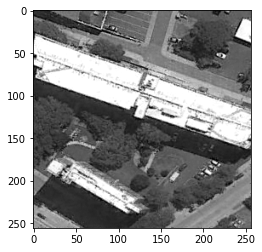

13187.png


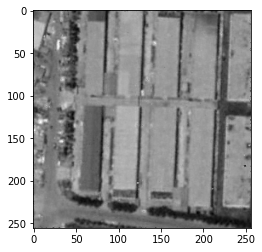

13207.png


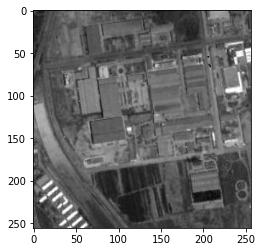

13200.png


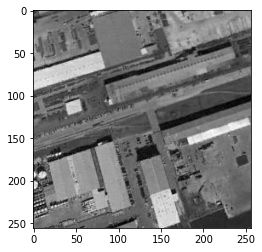

13191.png


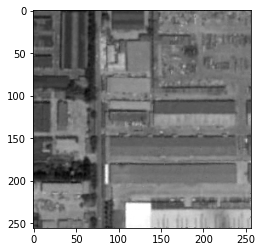

13221.png


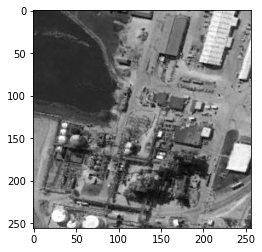

13222.png


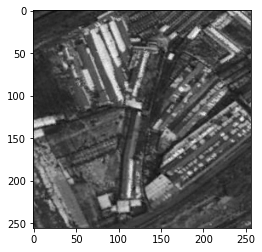

13203.png


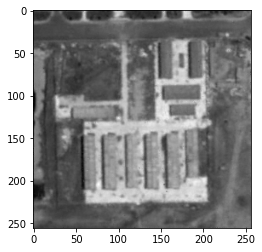

13211.png


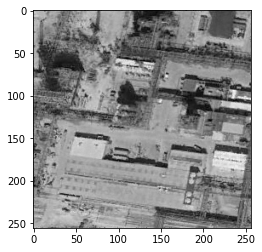

13237.png


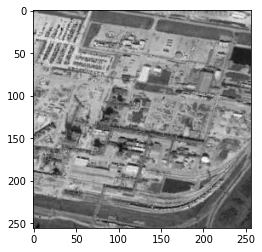

13242.png


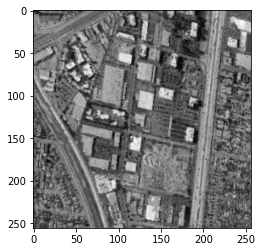

13240.png


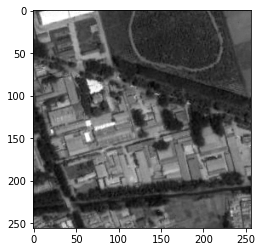

13238.png


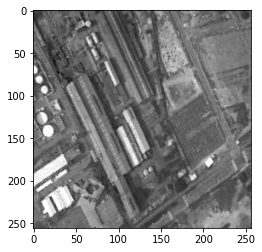

13249.png


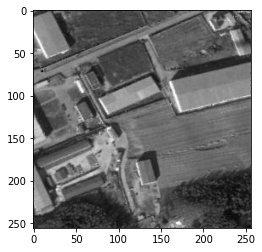

13243.png


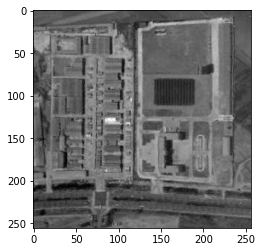

13248.png


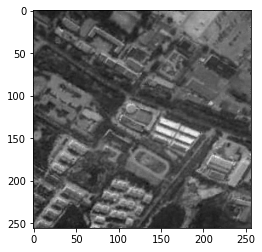

13250.png


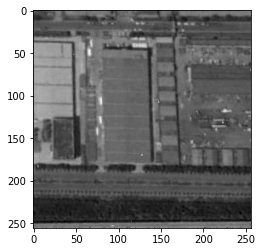

13239.png


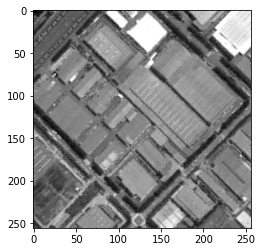

13244.png


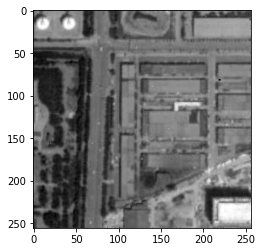

13245.png


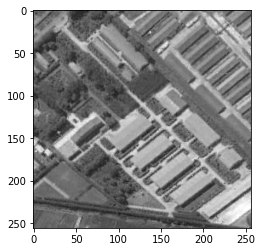

13232.png


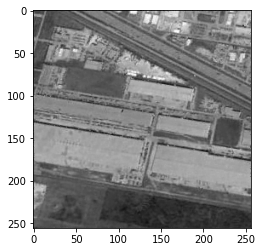

13235.png


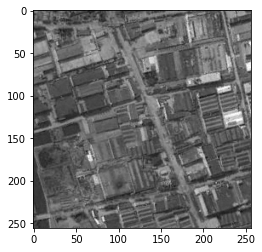

13234.png


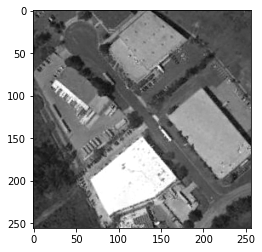

13247.png


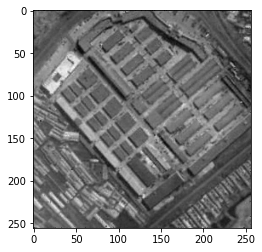

13233.png


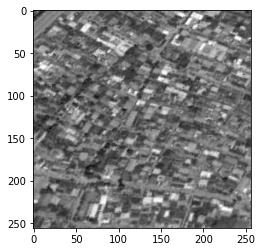

13241.png


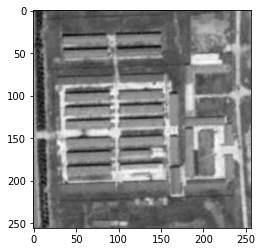

13236.png


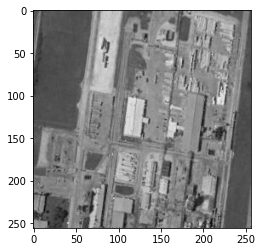

13246.png


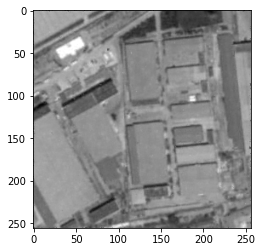

14000.png


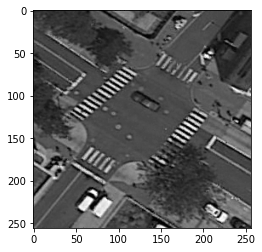

14122.png


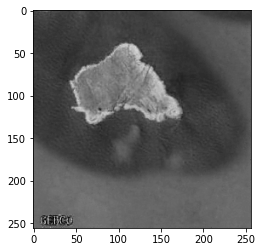

14127.png


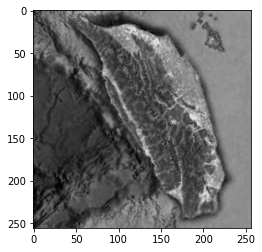

14130.png


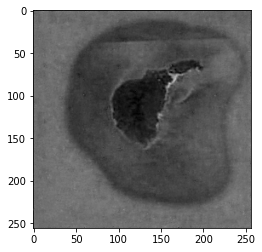

14112.png


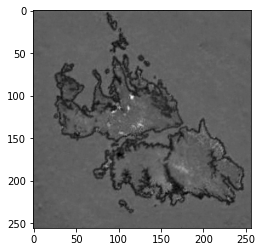

14101.png


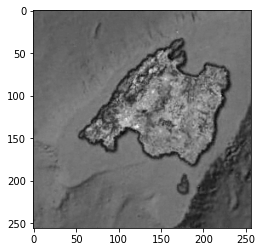

14126.png


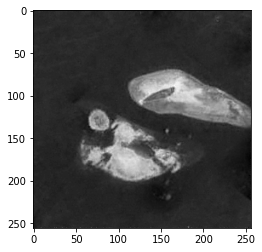

14116.png


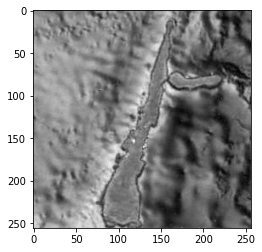

14125.png


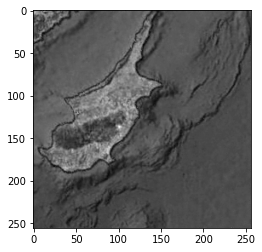

14106.png


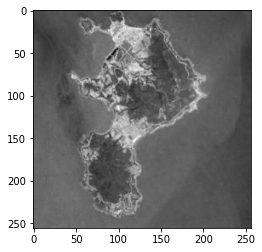

14132.png


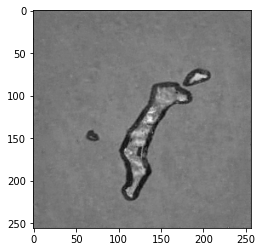

14105.png


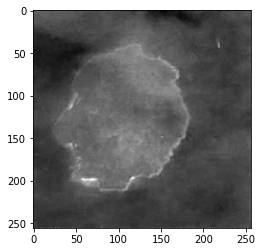

14114.png


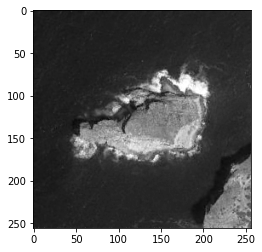

14129.png


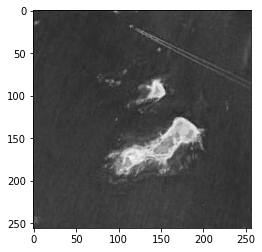

14119.png


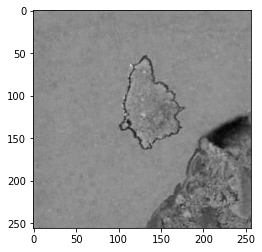

14104.png


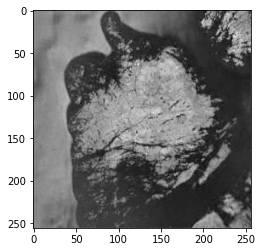

14121.png


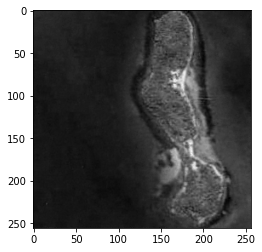

14103.png


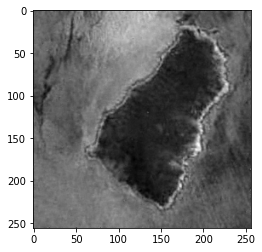

14124.png


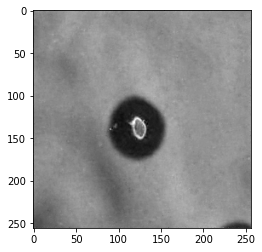

14108.png


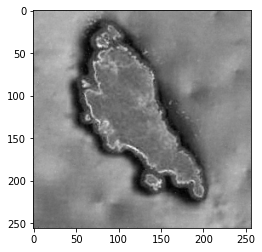

14110.png


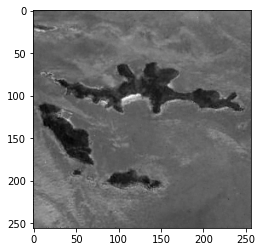

14111.png


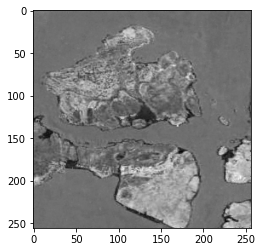

14107.png


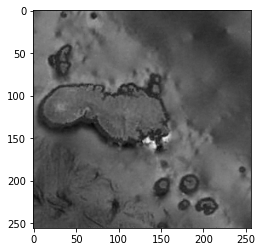

14100.png


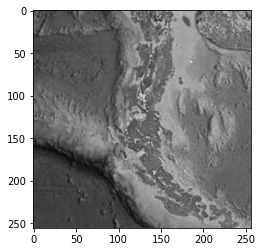

14131.png


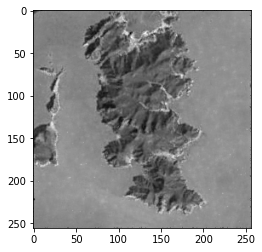

14123.png


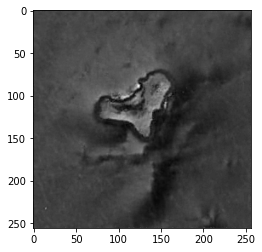

14128.png


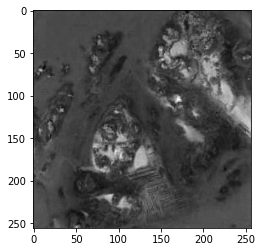

14118.png


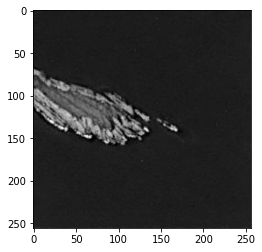

14120.png


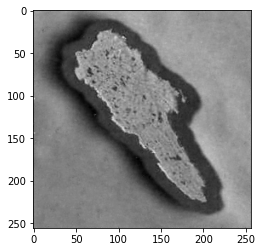

14113.png


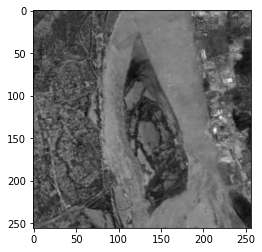

14102.png


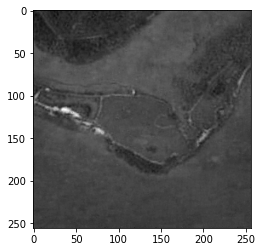

14117.png


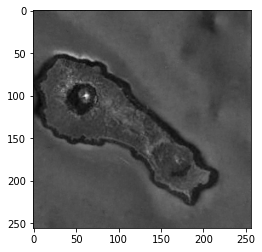

14109.png


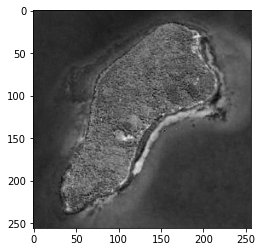

14115.png


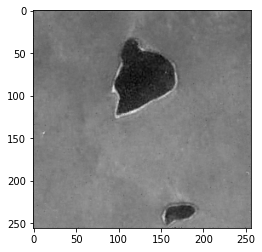

14136.png


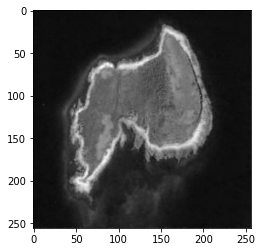

14146.png


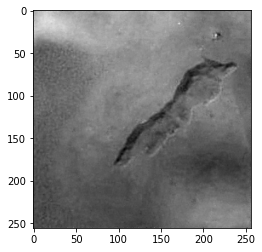

14138.png


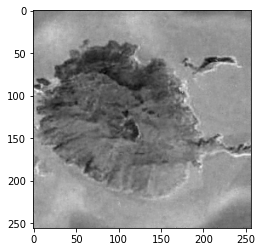

14168.png


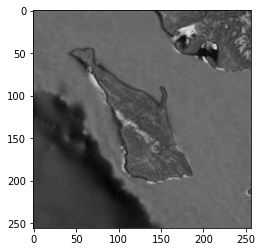

14150.png


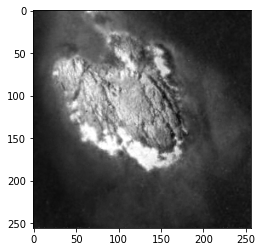

14161.png


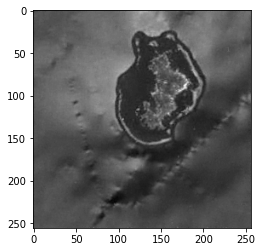

14164.png


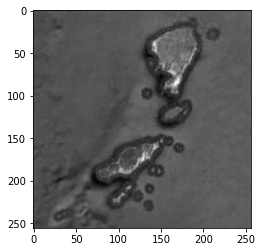

14140.png


KeyboardInterrupt: ignored

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab.patches import cv2_imshow

images= os.listdir('/content/drive/MyDrive/SAR_LPNET_NEW/test_img/results_with_attention_R_50 epoch/')
print(len(images))
print((images))
for i in range(len(images)):
  img = cv2.imread('/content/drive/MyDrive/SAR_LPNET_NEW/test_img/results_with_attention_R_50 epoch/'+images[i],0)
  name=images[i]
  print(name)
  gauss = np.random.normal(0.03,0.04,img.size) #base test
  # gauss = np.random.normal(0.3,0.6,img.size) proposed
  gauss = gauss.reshape(img.shape[0],img.shape[1]).astype('uint8')
  noise = img + img * gauss
  plt.imshow(noise[:,:],cmap='gray')
  plt.show()
  
  # cv2.imwrite(os.path.join('/content/drive/MyDrive/SAR_LPNET_NEW/test_img/487noisy' , name), noise)

